<a href="https://colab.research.google.com/github/england98/EST-Project-1-4/blob/Model/Finedust_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('/content/FineDust2.csv')
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240783 entries, 0 to 240782
Data columns (total 26 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   StationCode                240783 non-null  int64  
 1   Year                       240783 non-null  int64  
 2   Month                      240783 non-null  int64  
 3   Day                        240783 non-null  int64  
 4   Hour                       240783 non-null  int64  
 5   SO2                        234807 non-null  float64
 6   CO                         232664 non-null  float64
 7   O3                         233687 non-null  float64
 8   NO2                        234615 non-null  float64
 9   PM10                       232384 non-null  float64
 10  PM25                       225422 non-null  float64
 11  Temperature_C              240703 non-null  float64
 12  Precipitation_mm           23087 non-null   float64
 13  WindSpeed_mps              24

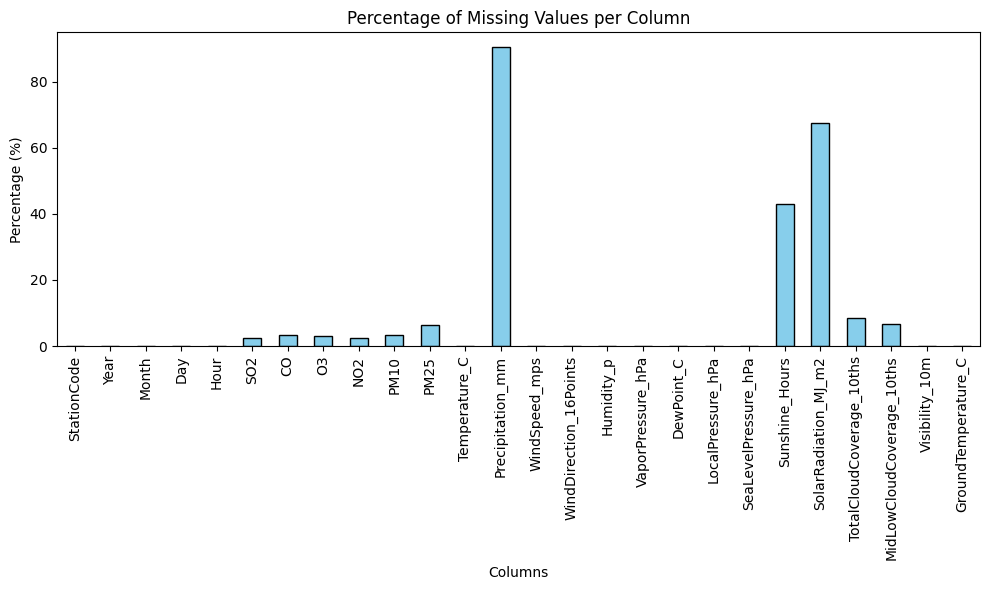

In [2]:
# 결측치 비율 확인
missing_percentage = data.isnull().mean() * 100

# 결측치 비율 시각화
plt.figure(figsize=(10, 6))
missing_percentage.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Percentage of Missing Values per Column')
plt.xlabel('Columns')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [2]:
data_filled = data
data_filled['Precipitation_mm'] = data['Precipitation_mm'].fillna(0,inplace=False)
data_filled = data_filled.fillna(data_filled.mean())

data_filled.isnull().sum()

,0
StationCode,0
Year,0
Month,0
Day,0
Hour,0
SO2,0
CO,0
O3,0
NO2,0
PM10,0


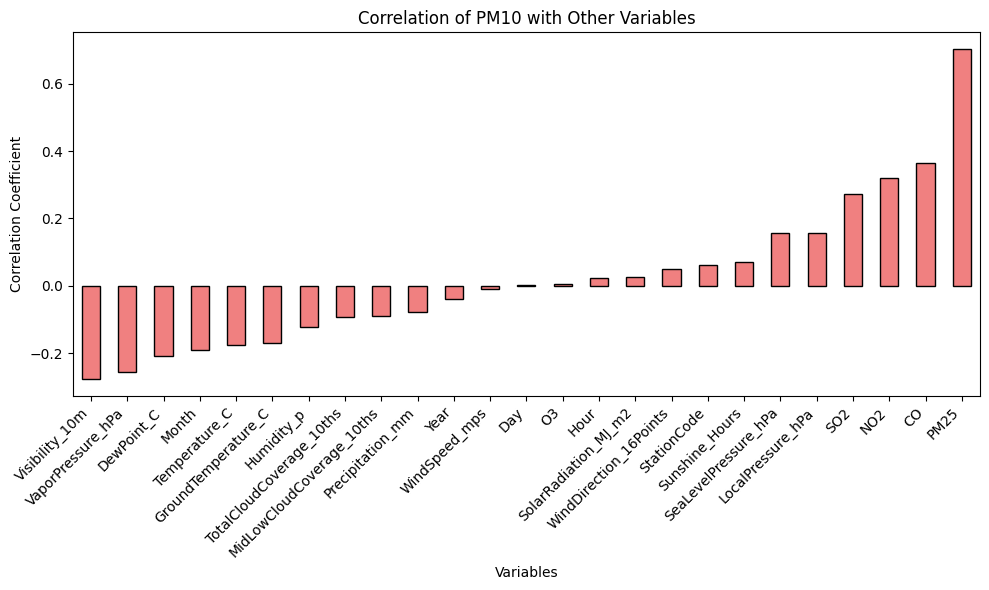

In [3]:
# 타겟 변수 (PM10)과의 상관관계 계산
pm10_correlation = data_filled.corr()["PM10"].drop("PM10").sort_values()

# Create a bar plot for PM10 correlation with other variables
plt.figure(figsize=(10, 6))
pm10_correlation.plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title('Correlation of PM10 with Other Variables')
plt.xlabel('Variables')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [4]:
# 상관관계가 0.2 이상인 열 추출
high_correlation_columns = pm10_correlation[pm10_correlation.abs() >= 0.2].index.tolist()

high_correlation_columns

['Visibility_10m',
 'VaporPressure_hPa',
 'DewPoint_C',
 'SO2',
 'NO2',
 'CO',
 'PM25']

In [5]:
# PM10 분포 3구간으로 구분
# 30 이하 : 낮음 // 30~80 : 보통 // 80 이상 : 높음

# 미세먼지 농도 기준 정의
conditions = [
    (data_filled['PM10'] <= 30),
    (data_filled['PM10'] > 30) & (data['PM10'] <= 80),
    (data_filled['PM10'] > 80)
]

# 기준에 맞게 데이터 분할
class_labels = ['Low', 'Medium', 'High']
data_filled['PM10_Class'] = pd.cut(data_filled['PM10'], bins=[-float('inf'), 30, 80, float('inf')], labels=class_labels)

# 각 class별 데이터 수 확인
data_filled['PM10_Class'].value_counts()




,count
PM10_Class,
Medium,114894
Low,106479
High,19410


In [6]:
data_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240783 entries, 0 to 240782
Data columns (total 27 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   StationCode                240783 non-null  int64   
 1   Year                       240783 non-null  int64   
 2   Month                      240783 non-null  int64   
 3   Day                        240783 non-null  int64   
 4   Hour                       240783 non-null  int64   
 5   SO2                        240783 non-null  float64 
 6   CO                         240783 non-null  float64 
 7   O3                         240783 non-null  float64 
 8   NO2                        240783 non-null  float64 
 9   PM10                       240783 non-null  float64 
 10  PM25                       240783 non-null  float64 
 11  Temperature_C              240783 non-null  float64 
 12  Precipitation_mm           240783 non-null  float64 
 13  WindSpeed_mps 

상관관계가 높은 feature로만 학습

['Visibility_10m', 'VaporPressure_hPa', 'DewPoint_C', 'SO2', 'NO2', 'CO', 'PM25']

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


In [ ]:
# 학습 데이터 준비 및 분할
X = data_filled[high_correlation_columns]
y = data_filled['PM10_Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Accuracy: 0.81

Classification Report:
              precision    recall  f1-score   support

        High       0.81      0.55      0.65      3914
         Low       0.82      0.86      0.84     21316
      Medium       0.80      0.81      0.80     22927

    accuracy                           0.81     48157
   macro avg       0.81      0.74      0.76     48157
weighted avg       0.81      0.81      0.81     48157



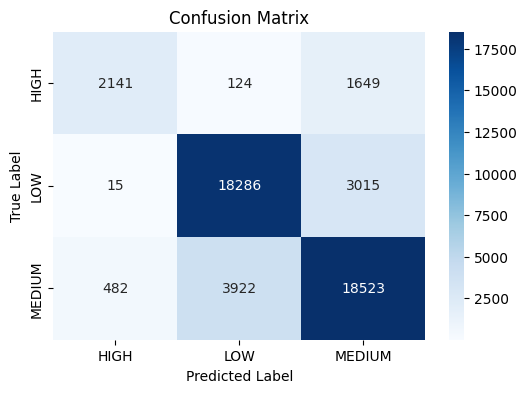

In [8]:
# Hyperparameter : Default

# 랜덤 포레스트 모델 생성 및 학습
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# 예측 및 평가
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Accuracy 및 Classifation Report 확인
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix 확인
confusion_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['HIGH', 'LOW', 'MEDIUM'], yticklabels=['HIGH', 'LOW', 'MEDIUM'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
# Random Search

# 랜덤 포레스트 모델 생성 및 학습
model_RS = RandomForestClassifier(random_state=42)

# 하이퍼파라미터 범위 설정
param_dist = {
    'n_estimators': [int(x) for x in np.linspace(start=100, stop=1000, num=10)],  # 트리 개수
    'max_depth': [int(x) for x in np.linspace(10, 110, num=11)] + [None],  # 최대 깊이
    'min_samples_split': [2, 5, 10],  # 노드 분할에 필요한 최소 샘플 수
    'min_samples_leaf': [1, 2, 4],  # 리프 노드에 필요한 최소 샘플 수
    'max_features': ['sqrt', 'log2']  # 각 분할에서 고려할 최대 특성 수
}

# Random Search 설정
random_search = RandomizedSearchCV(
    estimator=model_RS,
    param_distributions=param_dist,
    n_iter=100,  # 시도할 조합의 수
    cv=5,  # 교차 검증 폴드 수
    verbose=2,
    random_state=42,
    # n_jobs=-1,  # 가능한 모든 CPU 코어 사용
    scoring='accuracy'  # 평가 지표
)

# 모델 학습
random_search.fit(X_train, y_train)


# 최적의 파라미터 출력
print(f"Best parameters: {random_search.best_params_}")

# 예측 및 평가
best_model_RS = random_search.best_estimator_
y_pred = best_model_RS.predict(X_test)
y_proba = best_model_RS.predict_proba(X_test)[:, 1]

# Accuracy 및 Classifation Report 확인
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix 확인
confusion_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['HIGH', 'LOW', 'MEDIUM'], yticklabels=['HIGH', 'LOW', 'MEDIUM'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time= 4.3min
[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time= 4.3min
[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time= 4.3min
[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time= 4.3min
[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time= 4.3min
[CV] END max_depth=40, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=900; total time= 3.6min
[CV] END max_depth=40, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=900; total time= 3.6min
[CV] END max_depth=40, max_features=log2, min_samples_leaf=2, min_samples_split=2,

In [ ]:
### Colab GPU 사용량 제한으로 학습 중